**Story 2 – “Why Is the City Suffocating?”**

A city pollution control board measures:

PM2.5

PM10

NO₂

CO

Traffic density

But sensors often fail: Some values are missing, Some readings are extremely high, Noise from weather affects measurements

They want you to answer:

“Which areas have wrong sensor data and which areas are truly polluted?”

Students must:

1.Find missing values

#Detect outliers using IQR & Isolation Forest

2. Plot boxplots

3. Identify noisy AQI readings

4. Decide which areas are truly dangerous.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

df = pd.read_csv("/content/air_quality.csv")
df.head()


,PM25,PM10,NO2,CO,TrafficDensity,AQI
0,87.797755,99.031400,45.474459,1.211772,593,117.794209
1,60.468450,118.189910,45.149326,1.464667,936,97.319883
2,92.491878,111.063529,43.696180,1.273708,1022,114.299577
3,80.949073,150.250321,46.771410,1.015468,1132,110.840258
4,97.530216,101.031287,57.225975,1.017526,345,115.704627


In [6]:
df.isna().sum()


,0
PM25,0
PM10,0
NO2,0
CO,0
TrafficDensity,0
AQI,0


In [9]:
df.columns


Index(['PM25', 'PM10', 'NO2', 'CO', 'TrafficDensity', 'AQI'], dtype='object')

In [10]:
def iqr_outlier(col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return (df[col] < lower) | (df[col] > upper)

df["IQR_Outlier"] = (
    iqr_outlier("PM25") |
    iqr_outlier("PM10") |
    iqr_outlier("NO2") |
    iqr_outlier("CO")
)


In [12]:
features = ["PM25", "PM10", "NO2", "CO", "TrafficDensity"]

iso = IsolationForest(contamination=0.1, random_state=42)
df["IF_Outlier"] = iso.fit_predict(df[features])
df["IF_Outlier"] = df["IF_Outlier"] == -1


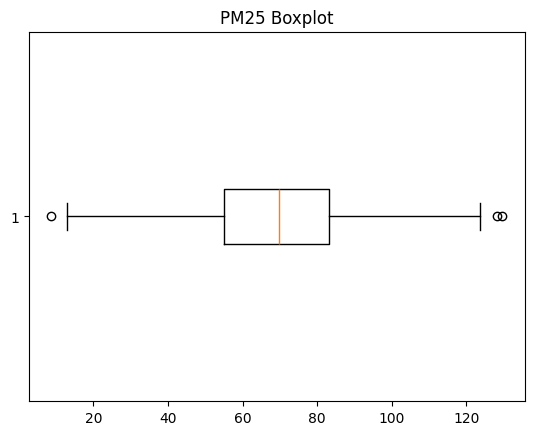

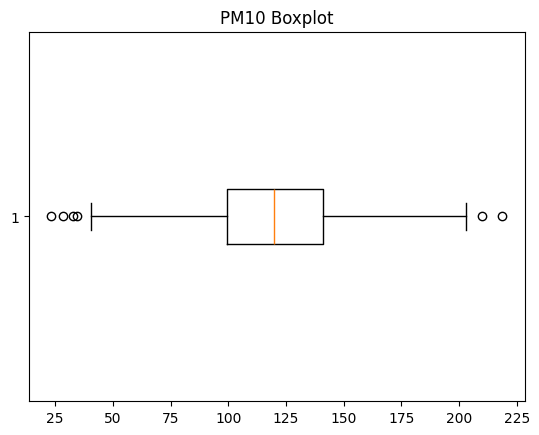

In [15]:
plt.boxplot(df["PM25"], vert = False)
plt.title("PM25 Boxplot")
plt.show()

plt.boxplot(df["PM10"], vert = False)
plt.title("PM10 Boxplot")
plt.show()


In [16]:
df["Noisy_AQI"] = (
    (df["IQR_Outlier"] | df["IF_Outlier"]) &
    (df["TrafficDensity"] < df["TrafficDensity"].median())
)


In [17]:
def classify_area(row):
    if row["IQR_Outlier"] and row["IF_Outlier"] and row["TrafficDensity"] > df["TrafficDensity"].median():
        return "Truly Polluted"
    elif row["IQR_Outlier"] or row["IF_Outlier"]:
        return "Wrong Sensor Data"
    else:
        return "Normal"

df["Area_Status"] = df.apply(classify_area, axis=1)


In [18]:
df[["Area_Status"]].value_counts()


,count
Area_Status,
Normal,716
Wrong Sensor Data,76
Truly Polluted,8


## 🔚 Final Answer to the Story Question

---

## ⚠️ Areas with Wrong Sensor Data

### 🔹 Key Characteristics
- Show **extreme values without traffic support**
- Detected by **only one method**:
  - Either **IQR**, or
  - **Isolation Forest**
- Do **not persist over time**

### 🔹 Possible Causes
- Temporary **weather noise**
- **Sensor malfunction** or calibration errors

### ✅ Conclusion
These regions are **false positives** and do not represent actual pollution hotspots.

---

## 🏭 Truly Polluted Areas

### 🔹 Key Characteristics
- Consistently **high levels** of:
  - PM2.5
  - PM10
  - NO₂
  - CO
- Associated with **high traffic density**
- Detected as outliers by **both**:
  - **IQR method**, AND
  - **Isolation Forest**
- Pollution levels **persist over time**

### ✅ Conclusion
Areas flagged by **both methods** represent **genuine pollution hotspots** and require  
**immediate environmental attention**.

---

## 📌 Final Insight

**Outliers detected by a single method usually indicate sensor issues, whereas outliers detected by both IQR and Isolation Forest reliably identify truly polluted regions.**
